## Import Datasets and Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
score_method = "sft"
dataset = "ultra"
alias = "3ep"
var_method = "proxy"
corr_method = "cosine"
rating = "fine-grained"
#"
cfg = {
"fig_input_path": f"/home/eunwon/Dataset-Cartography-for-Alignment/results/{score_method}_{dataset}_{alias}_{var_method}_{corr_method}_{rating}.jsonl",
"title": f"{score_method} / dataset: {dataset}/ {alias} / {var_method} / {corr_method} / {rating}",
"min_cosine_similarity": 0,
"max_cosine_similarity": 1,
"fig_output_path": f"../results/{score_method}_{var_method}_{corr_method}.png"
}


def load_processed_data(open_json):
    with open(open_json, 'r') as file:
        data = [json.loads(line) for line in file.readlines()]
    return data


data = load_processed_data(cfg["fig_input_path"])
print(f"len(data): {len(data)}")

len(data): 19579


In [4]:
scores = []
gpt_scores = []

def sigmoid(x): return 1 / (1 + np.exp(-x))
                            
scores = [ item['scores'] for item in data]
scores_avg = [(np.mean(prob)) for prob in scores]
#scores_avg = [(gpt_scores[i]/np.mean(scores[i])) for i in range(len(data))]
score_variance = [item['score_variance'] for item in data]
correlation = [item['correlation'] for item in data]
instruction = [item['instruction'] for item in data]
gpt_inference = [item['gpt_inference'] for item in data]

response = []
for item in data:
    response_str = ""
    for i in range(len(item['completions'])):
        response_str += item['completions'][i]['response']
        if i != 3:
            response_str += ", "
    response.append(response_str)


combined_df = pd.DataFrame({
    'score_avg': scores_avg,
    'scores': scores,
    'score_variance': score_variance,
    'correlation': correlation,
    'response': response,
    'instruction': instruction,
    'gpt_inference': gpt_inference
})



## Draw Basic Scatter Plots

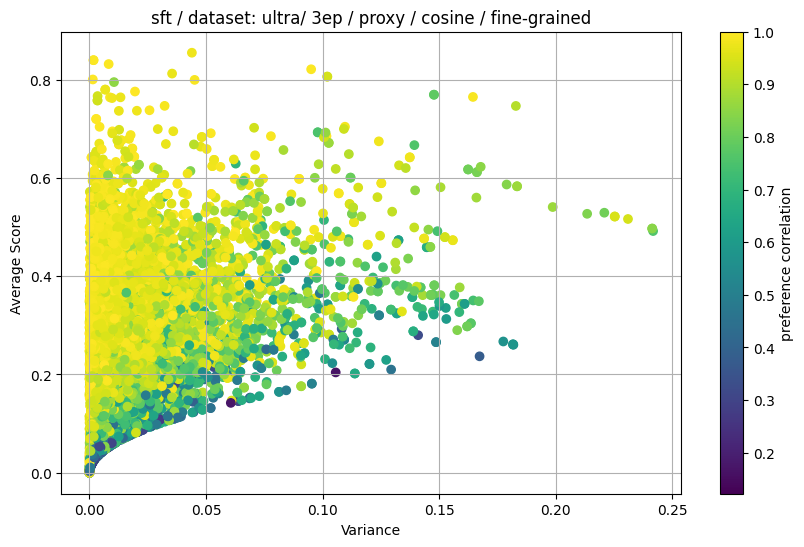

In [5]:
# Scatter plot with variance on the x-axis and score_avg on the y-axis, colored by score_avg
plt.figure(figsize=(10, 6))
scatter = plt.scatter(combined_df['score_variance'], combined_df['score_avg'], c=combined_df['correlation'], cmap='viridis', alpha=1)
plt.xlabel('Variance')
plt.ylabel('Average Score')
plt.title(cfg['title'])
plt.colorbar(scatter, label='preference correlation')
plt.grid(True)
plt.show()

## Draw Bin plots

In [6]:
filtered_df = combined_df[combined_df['correlation'] > 0]
filtered_df = filtered_df[filtered_df['correlation'] < 0.95]
min_correlation = filtered_df['correlation'].min()
print(f"The minimum cosine similarity in the filtered dataframe is: {min_correlation}")

The minimum cosine similarity in the filtered dataframe is: 0.12201901288547654


## Dataset Cartography Style Plots

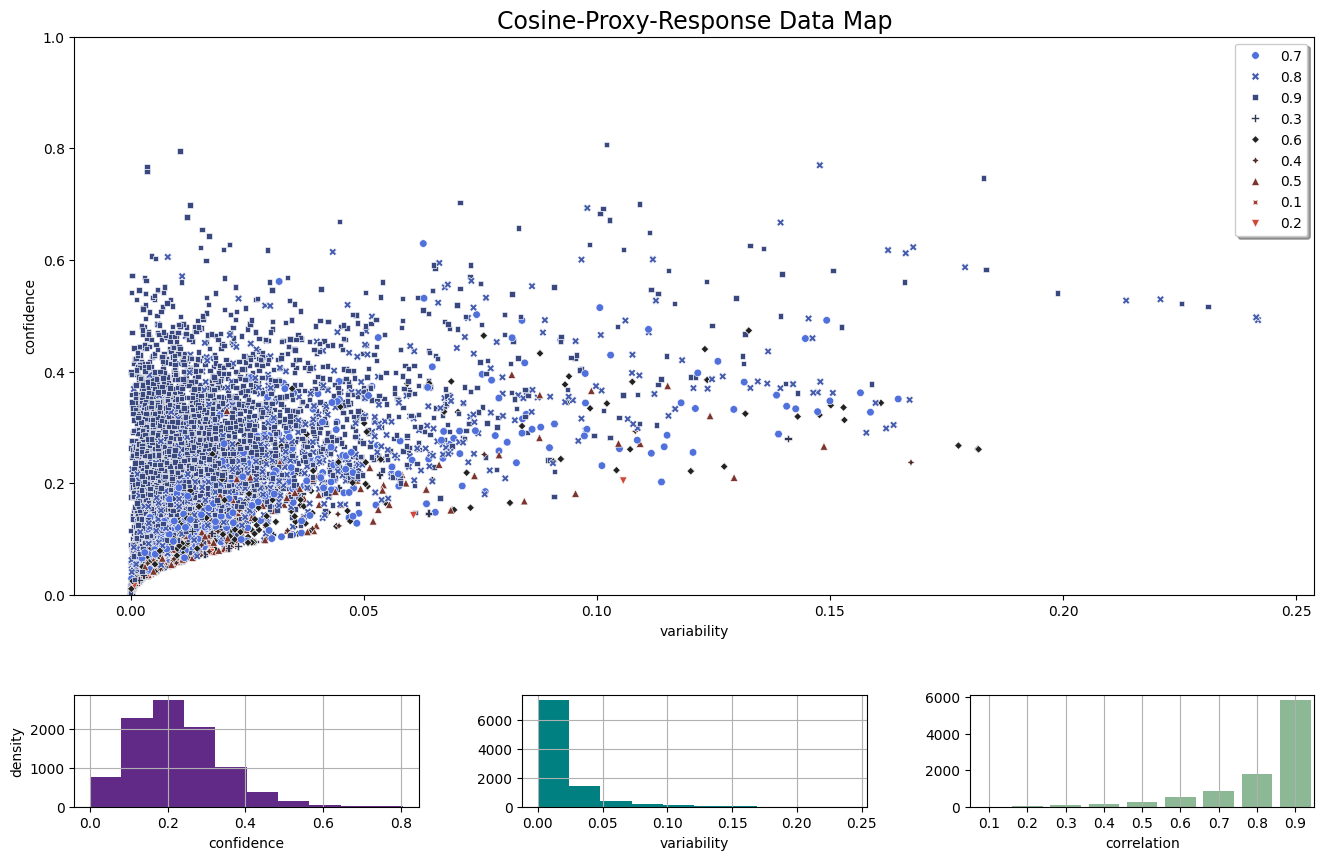

In [7]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='Cosine', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correlation / d.correlation.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['correlation']]
    
    main_metric = 'score_variance'
    other_metric = 'score_avg'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[0, :])
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    # bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    # an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", rotation=350, bbox=bb('black'))
    # an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('r'))
    # an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['score_avg'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['score_variance'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        #오름차순 정렬 plot2 
        sorted_order = sorted(dataframe['correct.'].unique(), key=lambda x: float(x))

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3, order=sorted_order)
        ax3.xaxis.grid(True)  # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correlation')
        plot2.set_ylabel('')

    # fig.tight_layout()
    # filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    # fig.savefig(filename, dpi=300)

scatter_it(filtered_df, title='Proxy-Response', show_hist=True)

In [19]:
filtered_df = combined_df[combined_df['correlation'] > 0.95]
filtered_df = filtered_df[filtered_df['correlation'] < 1]
min_correlation = filtered_df['correlation'].min()
print(f"The minimum cosine similarity in the filtered dataframe is: {min_correlation}")

The minimum cosine similarity in the filtered dataframe is: 0.9500025733210389


cor_33: 0.9177867058415088, cor_66: 0.97084491736535
The minimum cosine similarity in the filtered dataframe is: 0.12201901288547654
correlation range: (0, 0.95)
len(filtered_df): 9485
The minimum cosine similarity in the filtered dataframe is: 0.12201901288547654
correlation range: (-1, 1)
len(filtered_df): 19572
The minimum cosine similarity in the filtered dataframe is: 0.12201901288547654
correlation range: (0, 0.6)
len(filtered_df): 722
The minimum cosine similarity in the filtered dataframe is: 0.9500075496289532
correlation range: (0.95, 1)
len(filtered_df): 10087


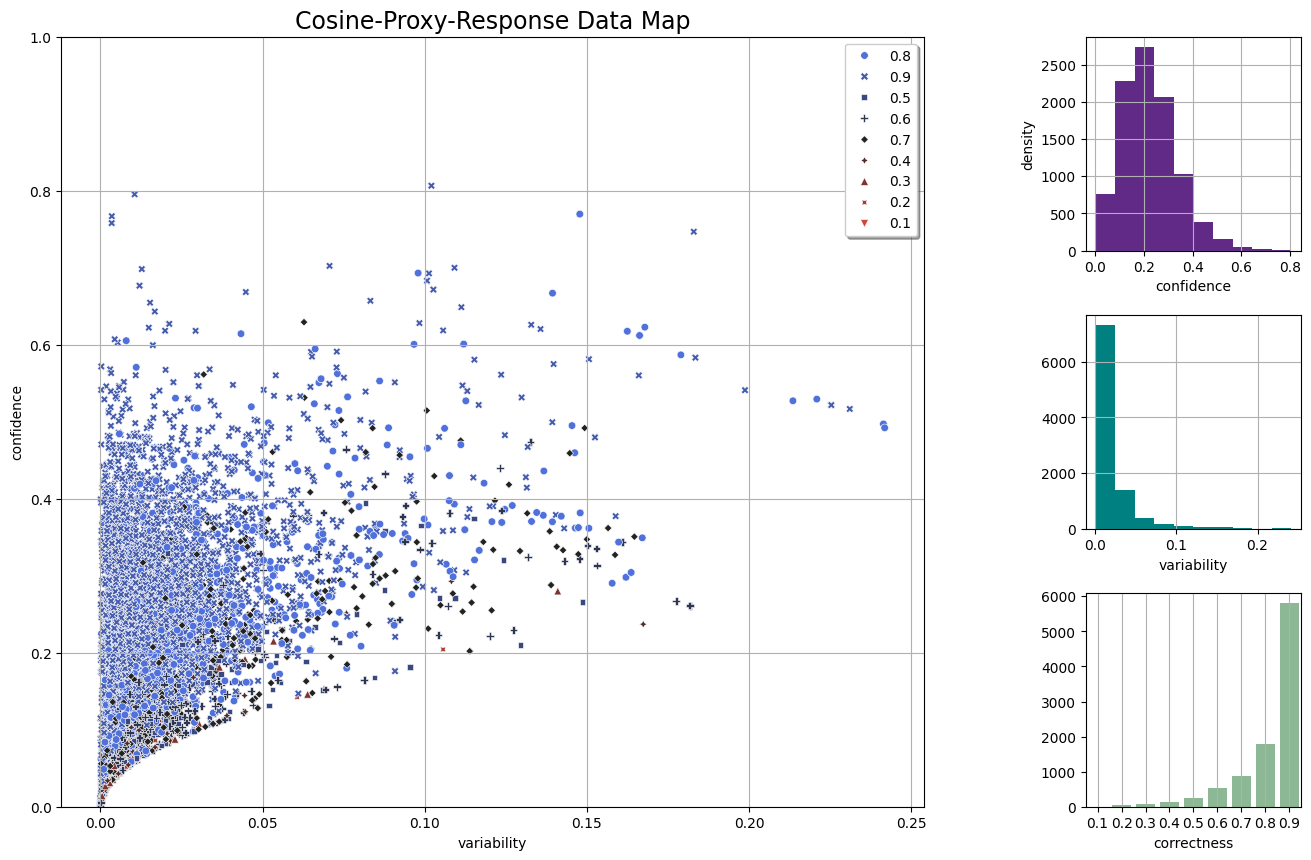

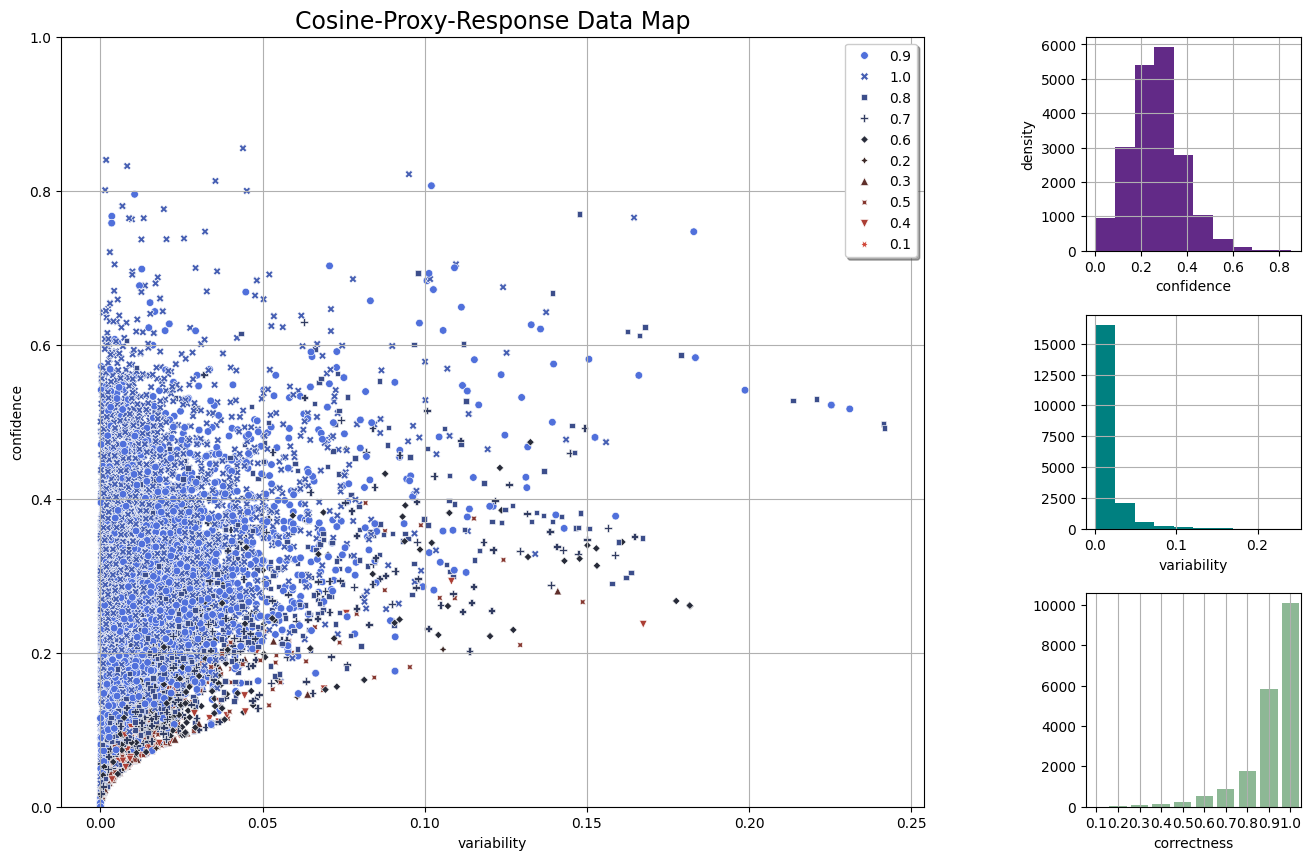

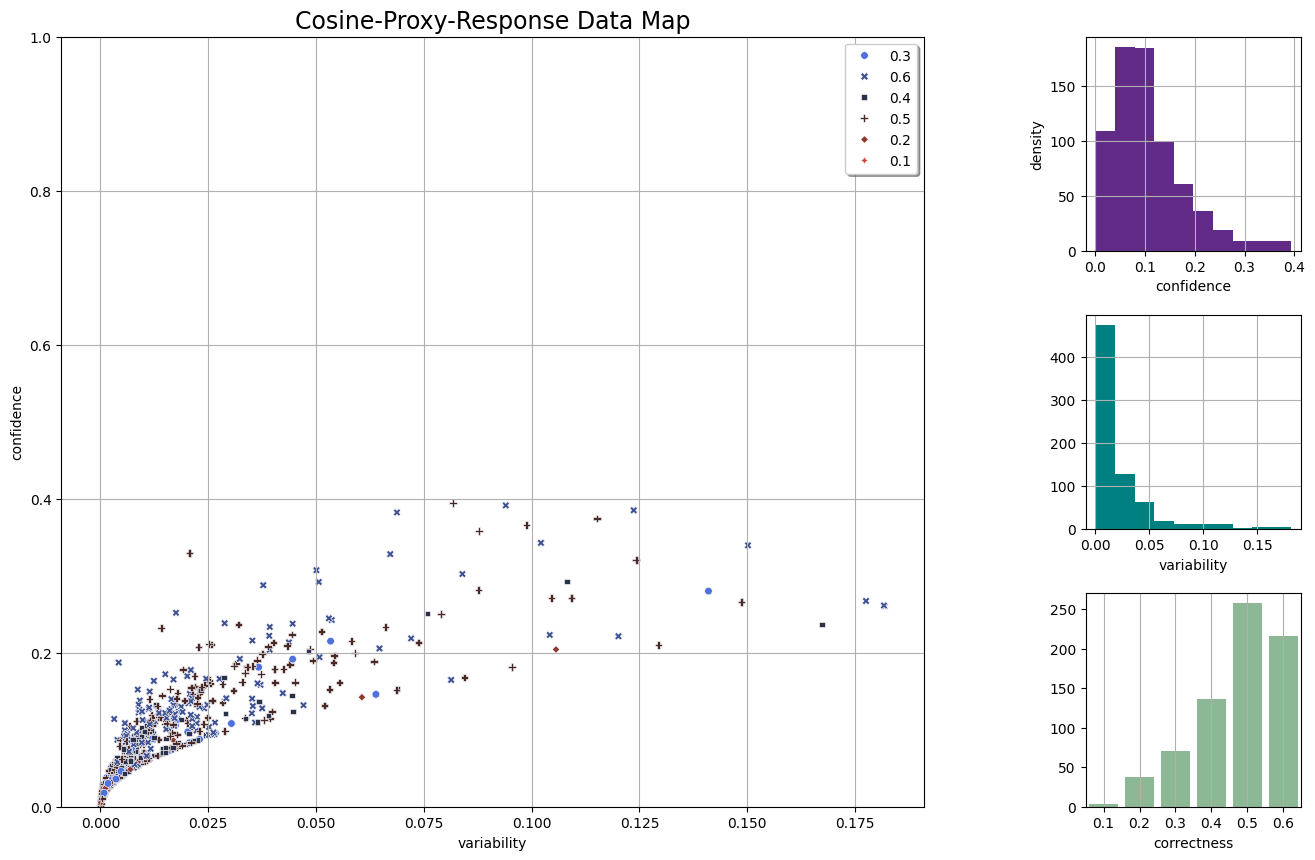

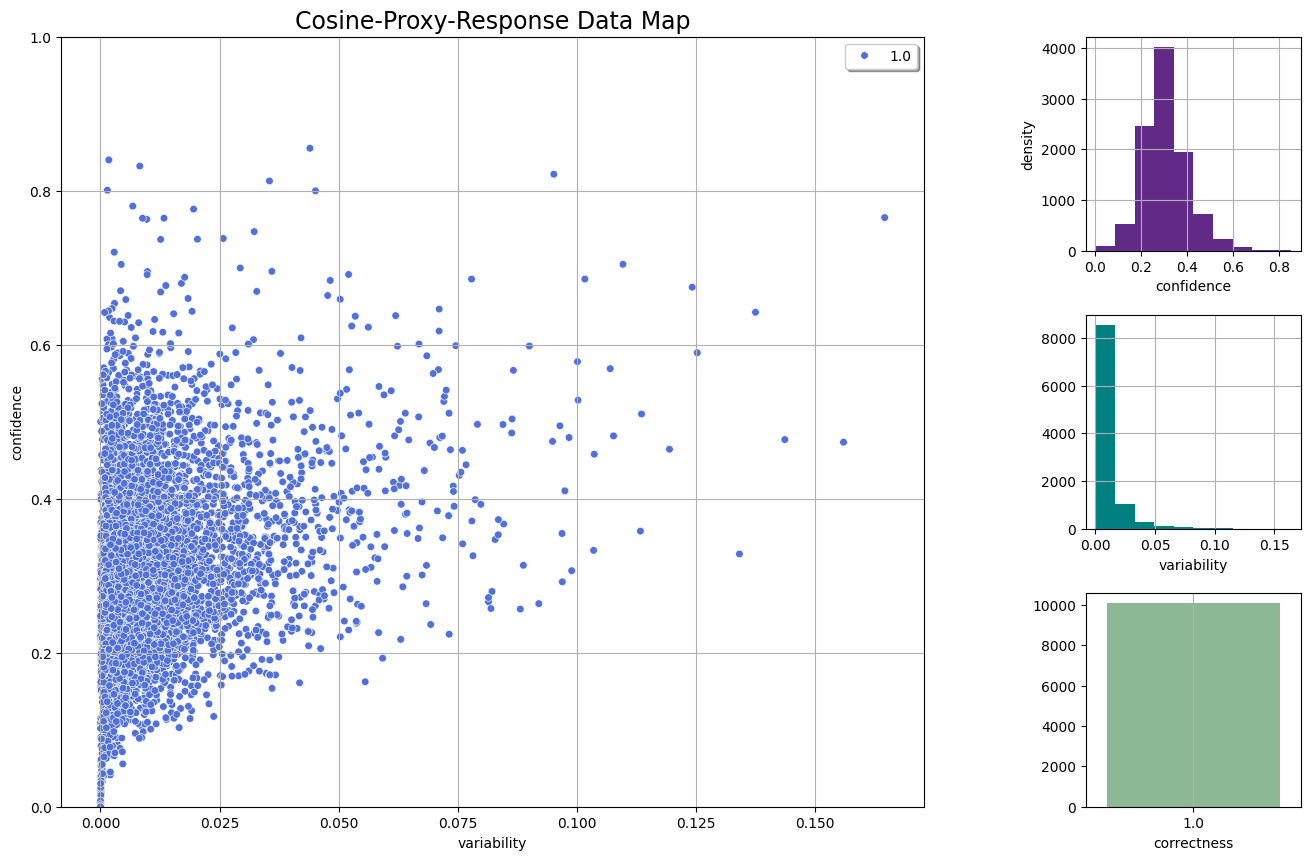

In [11]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='Cosine', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correlation / d.correlation.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['correlation']]
    
    main_metric = 'score_variance'
    other_metric = 'score_avg'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.grid(True)
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])  
        ax0 = fig.add_subplot(gs[0, 0]) 
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.grid(True)
    
    
    ### Make the scatterplot.

    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    # bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    # an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", rotation=350, bbox=bb('black'))
    # an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('r'))
    # an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        right_gs = gs[0, 1].subgridspec(3, 1, height_ratios=[1, 1, 1])  
        ax1 = fig.add_subplot(right_gs[0, 0])
        ax2 = fig.add_subplot(right_gs[1, 0])  
        ax3 = fig.add_subplot(right_gs[2, 0]) 

        plott0 = dataframe.hist(column=['score_avg'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['score_variance'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        sorted_order = sorted(dataframe['correct.'].unique(), key=lambda x: float(x))


        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3, order=sorted_order)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    # fig.tight_layout()
    # filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    # fig.savefig(filename, dpi=300)

correlation_min_max = [(0, 0.95), (-1,1), (0, 0.6), (0.95, 1)]
cor_33, cor_66 = combined_df['correlation'].quantile([0.33, 0.66])
print(f"cor_33: {cor_33}, cor_66: {cor_66}")
for min_max in correlation_min_max:
    filtered_df = combined_df[combined_df['correlation'] > min_max[0]]
    filtered_df = filtered_df[filtered_df['correlation'] < min_max[1]]
    min_correlation = filtered_df['correlation'].min()
    print(f"The minimum cosine similarity in the filtered dataframe is: {min_correlation}")
    print(f"correlation range: {min_max}")
    print(f"len(filtered_df): {len(filtered_df)}")
    scatter_it(filtered_df, title='Proxy-Response', show_hist=True)